# Knowledge Graph Retriever

A knowledge graph is an organized representation of real-world entities and their relationships. It is typically stored in a graph database, which natively stores the relationships between data entities. Entities in a knowledge graph can represent objects, events, situations, or concepts. The relationships between these entities capture the context and meaning of how they are connected.

A knowledge graph stores data and relationships alongside frameworks known as organizing principles. They can be thought of as rules or categories around the data that provide a flexible, conceptual structure to drive deeper data insights. The usefulness of a knowledge graph lies in the way it organizes the principles, data, and relationships to surface new knowledge for your user or business. The design is useful for many usage patterns, including real-time applications, search and discovery, and grounding generative AI for question-answering.

## Constructing knowledge graphs

Before we jump right in and start asking questions or stuff, we need to build the knowledge graph which will be used as a knowledge base for RAG agent.

### Architecture  
At a high-level, the steps of constructing a knowledge are from text are:

1. **Extracting structured information from text:** Model is used to extract structured graph information from text.
2. **Storing into graph database:** Storing the extracted structured graph information into a graph database enables downstream RAG applications

### Setup
First, get required packages and set environment variables.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv

load_dotenv()

import os

# os.environ["OPENAI_API_KEY"] = getpass.getpass()

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

Next, we need to define Neo4j credentials and connection. Follow these [installation steps](https://neo4j.com/docs/operations-manual/current/installation/) to set up a Neo4j database.

In [2]:
from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

graph = Neo4jGraph()

### Here, let's take a look at our aimed taxonomy.

![ontology](figures/ontology.svg)

### Build the graph (structured)

#### Load the csv

Load and add related_docs column

In [3]:
import pandas as pd


def add_related_docs(df):
    # Create a dictionary where each Family Title maps to a list of Document IDs
    family_title_dict = df.groupby('Family Title')['Document ID'].apply(list).to_dict()

    # Create a new column 'related_docs' by applying a function that looks up related documents excluding the current row's Document ID
    df['related_docs'] = df.apply(lambda row: [doc_id for doc_id in family_title_dict.get(row['Family Title'], []) if doc_id != row['Document ID']], axis=1)

    return df


policy_df = pd.read_csv('csv/all_data_en.csv')

# Apply the function to add the 'related_docs' column
policy_df = add_related_docs(policy_df)

policy_df.head()

,index,Document ID,Document Title,Family ID,Family Title,Family Summary,Collection Title(s),Collection Description(s),Document Role,Document Variant,...,Last Modified on System,Internal Document ID,Internal Family ID,Internal Collection ID(s),have_support_doc?,raw_doc_path,doc_id,text_file_path,lang,related_docs
0,0,act-on-the-promotion-of-the-development-use-an...,"Act on the Promotion of the Development, Use a...",act-on-the-promotion-of-the-development-use-an...,"Act on the Promotion of the Development, Use a...",The revised Act on the Promotion of the Develo...,NaN,NaN,Main,Original Language,...,2024-08-21,CPR.document.i00000606.n0000,CPR.family.i00000605.n0000,NaN,True,climate_laws/1_pdfs/document_0.pdf,document_0,../climate_laws\en_cleaned_text_1\document_0.txt,en,[]
1,4728,national-redd-strategy-2017-2027-nec-decision-...,National REDD+ Strategy 2017-2027 (NEC decisio...,national-redd-strategy-2017-2027-nec-decision-...,National REDD+ Strategy 2017-2027 (NEC decisio...,The strategy is a key part of the country's re...,NaN,NaN,Main,NaN,...,2024-07-18,CCLW.executive.8702.1454,CCLW.family.8702.0,NaN,True,climate_laws/1_pdfs/document_4628.pdf,document_4628,../climate_laws\en_cleaned_text_2\document_462...,en,[]
2,4740,act-on-the-improvement-of-energy-consumption-p...,Act on the Improvement of Energy Consumption P...,act-on-the-improvement-of-energy-consumption-p...,Act on the Improvement of Energy Consumption P...,This Act provides for 1) regulatory measures f...,NaN,NaN,Main,NaN,...,2024-07-18,CCLW.legislative.8650.1498,CCLW.family.8650.0,NaN,True,climate_laws/1_pdfs/document_4640.pdf,document_4640,../climate_laws\en_cleaned_text_1\document_464...,en,[]
3,4739,climate-protection-policy-executive-summary_4e45,Climate Protection Policy: Executive Summary,climate-protection-policy-government-resolutio...,"Climate Protection Policy, Government Resoluti...",The Climate Protection Policy (CPP) of 2017 is...,NaN,NaN,Summary,NaN,...,2024-07-18,CCLW.executive.8657.1515,CCLW.family.8657.0,NaN,True,climate_laws/1_pdfs/document_4639.pdf,document_4639,../climate_laws\en_cleaned_text_1\document_463...,en,[]
4,4736,forest-law-of-the-people-s-republic-of-china_7bd3,Forest Law of the People's Republic of China,forest-law-of-the-people-s-republic-of-china_15c2,Forest Law of the People's Republic of China,"This law aims at protecting, cultivating and r...",NaN,NaN,Main,NaN,...,2024-07-18,CCLW.legislative.8675.4599,CCLW.family.8675.0,NaN,True,climate_laws/7_pdfs/document_4636.pdf,document_4636,../climate_laws\en_cleaned_text_1\document_463...,en,[]


In [4]:
region = pd.read_csv('csv/region.csv')
region = region[['alpha-3', 'region', 'sub-region', 'intermediate-region']]
region.head()

,alpha-3,region,sub-region,intermediate-region
0,AFG,Asia,Southern Asia,NaN
1,ALA,Europe,Northern Europe,NaN
2,ALB,Europe,Southern Europe,NaN
3,DZA,Africa,Northern Africa,NaN
4,ASM,Oceania,Polynesia,NaN


Merge region into policy_df

In [5]:
policy_df = policy_df.merge(region, left_on='Geography ISO', right_on='alpha-3', how='left')

In [6]:
print('Number of English Policies: ', len(policy_df))

Number of English Policies:  1243


#### Functions to build a graph based on defined ontology first

Functions

In [7]:
def create_policy_document(document_id, title, category, role, last_change):
    cypher = """
    MERGE (pd:PolicyDocument {documentId: $document_id})
    SET pd.title = $title
    SET pd.category = $category
    SET pd.role = $role
    SET pd.last_change = $last_change
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'title': title,
            'category': category,
            'role': role,
            'last_change': last_change
        }
    )


def link_approval_date(document_id, approval_year):
    cypher = """
    MERGE (ad:ApprovalYear {year: $approval_year})
    WITH ad
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:EFFECTIVE_FROM]->(ad)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'approval_year': approval_year,
        }
    )


def link_document_type(document_id, document_type):
    cypher = """
    MERGE (dt:DocumentType {type: $document_type})
    WITH dt
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:IS_OF_TYPE]->(dt)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'document_type': document_type,
        }
    )

In [8]:
def link_geography_hierarchy(hierarchy_levels):
    """
    Constructs and links geographical nodes in a hierarchy based on your specified order.

    Parameters:
    hierarchy_levels: A list of dictionaries representing the geographical hierarchy.
    Each dictionary should have 'type', 'name', and 'code' keys.

    Example:
    [
        {'type': 'Country', 'name': 'CountryName', 'code': 'CN'},
        {'type': 'SubRegion', 'name': 'SubRegionName', 'code': 'SR'},
        {'type': 'Region', 'name': 'RegionName', 'code': 'RN'}
    ]
    """
    allowed_geography_types = ['Country', 'SubRegion', 'Region']
    params = {}
    cypher_parts = []

    # Filter out levels with missing 'name' or 'code'
    valid_hierarchy_levels = []
    for level in hierarchy_levels:
        geography_type = level.get('type')
        geography_name = level.get('name')
        geography_code = level.get('code')

        if geography_type not in allowed_geography_types:
            raise ValueError(f"Invalid geography type: {geography_type}")

        if geography_name and geography_code:
            valid_hierarchy_levels.append(level)
        else:
            # Skip this level if 'name' or 'code' is missing
            continue

    # Ensure that we have at least one level to create nodes
    if not valid_hierarchy_levels:
        raise ValueError("At least one valid geography level with 'name' and 'code' is required.")

    # Build the Cypher query
    for idx in range(len(valid_hierarchy_levels) - 1):
        child = valid_hierarchy_levels[idx]
        parent = valid_hierarchy_levels[idx + 1]

        child_alias = f'geo_child_{idx}'
        parent_alias = f'geo_parent_{idx}'

        # Parameters for child
        params[f'{child_alias}_name'] = child['name']
        params[f'{child_alias}_code'] = child['code']
        # Parameters for parent
        params[f'{parent_alias}_name'] = parent['name']
        params[f'{parent_alias}_code'] = parent['code']

        # Merge child node
        cypher_parts.append(f"""
        MERGE ({child_alias}:{child['type']} {{code: ${child_alias}_code}})
        SET {child_alias}.name = ${child_alias}_name
        """.strip())

        # Merge parent node
        cypher_parts.append(f"""
        MERGE ({parent_alias}:{parent['type']} {{code: ${parent_alias}_code}})
        SET {parent_alias}.name = ${parent_alias}_name
        """.strip())

        # Create IS_PART_OF relationship
        cypher_parts.append(f"""
        MERGE ({child_alias})-[:IS_PART_OF]->({parent_alias})
        """.strip())

    # Handle the last node if not already merged
    if len(valid_hierarchy_levels) == 1:
        # Only one level, merge it without relationships
        level = valid_hierarchy_levels[0]
        alias = 'geo_single'
        params[f'{alias}_name'] = level['name']
        params[f'{alias}_code'] = level['code']

        cypher_parts.append(f"""
        MERGE ({alias}:{level['type']} {{code: ${alias}_code}})
        SET {alias}.name = ${alias}_name
        """.strip())

    # Combine all Cypher parts
    cypher_query = '\n'.join(cypher_parts)

    # Execute the query
    graph.query(cypher_query, params=params)


def link_document_geography(document_id, geography_type, geography_name):
    # Validate geography_type
    allowed_geography_types = ['Country', 'Region', 'SubRegion']
    if geography_type not in allowed_geography_types:
        raise ValueError(f"Invalid geography type: {geography_type}")

    cypher = f"""
    MATCH (pd:PolicyDocument {{documentId: $document_id}})
    MERGE (geo:{geography_type} {{name: $geography_name}})
    MERGE (geo)-[:APPLIES]->(pd)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'geography_name': geography_name,
        }
    )

Utils function for spliting text

In [9]:
def split_info(text):
    if pd.isna(text):
        return []
    return text.split(';')

Functions for other entities

In [10]:
def link_sector(document_id, sector):
    cypher = """
    MERGE (st:Sector {name: $name})
    WITH st
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:HAS_TARGET_SECTOR]->(st)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'name': sector,
        }
    )


def link_hazard(document_id, hazard):
    cypher = """
    MERGE (hz:Hazard {name: $name})
    WITH hz
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:ADDRESSES_HAZARD]->(hz)
    WITH hz, pd
    MATCH (pd)-[:APPLIES_TO]->(geo:Country)
    MERGE (geo)-[:AT_RISK_OF]->(hz)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'name': hazard,
        }
    )


def link_framework(document_id, framework):
    cypher = """
    MERGE (fw:Framework {name: $name})
    WITH fw
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:IS_OF_FRAMEWORK]->(fw)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'name': framework,
        }
    )


def link_keyword(document_id, keyword):
    cypher = """
    MERGE (kw:Keyword {name: $word})
    WITH kw
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:HAS_KEYWORD]->(kw)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'word': keyword,
        }
    )


def link_topic(document_id, topic):
    cypher = """
    MERGE (tp:Topic {name: $topic})
    WITH tp
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pd)-[:HAS_TARGET_TOPIC]->(tp)
    """
    graph.query(
        cypher,
        params={
            'document_id': document_id,
            'topic': topic,
        }
    )


def link_policy_instrument(document_id, instrument_string):
    """
    Links a policy instrument to a policy document and its instrument type in the graph database.

    Parameters:
    - document_id: The ID of the policy document.
    - instrument_string: The instrument string containing the policy instrument and optional instrument type,
                         separated by '|'. Example: "Carbon Tax|Economic Instrument"

    This function performs the following actions:
    - Creates or matches a PolicyInstrument node.
    - Links the PolicyDocument to the PolicyInstrument with a USES_INSTRUMENT relationship.
    - If an instrument type is provided, creates or matches an InstrumentType node.
    - Links the PolicyInstrument to the InstrumentType with an IS_OF_CLASS relationship.
    """

    # Split the instrument string by '|'
    parts = instrument_string.split('|')
    policy_instrument = parts[0].strip() if parts[0] else None

    if not policy_instrument:
        raise ValueError("Policy instrument name is missing.")

    instrument_type = parts[1].strip() if len(parts) > 1 else None

    # Prepare Cypher query and parameters
    params = {
        'document_id': document_id,
        'instrument_name': policy_instrument,
    }

    cypher = """
    MATCH (pd:PolicyDocument {documentId: $document_id})
    MERGE (pi:PolicyInstrument {name: $instrument_name})
    MERGE (pd)-[:USES_INSTRUMENT]->(pi)
    """

    if instrument_type:
        params['instrument_type'] = instrument_type
        cypher += """
        MERGE (it:InstrumentType {name: $instrument_type})
        MERGE (pi)-[:IS_OF_CLASS]->(it)
        """

    # Execute the query
    graph.query(cypher, params=params)

#### Running the building process

In [11]:
# from tqdm.notebook import tqdm

# # Loop through each row in dataframe and process
# for _, row in tqdm(policy_df.iterrows(), total=len(policy_df), desc='Creating Nodes and Relationships'):
#     # Create policy document node
#     create_policy_document(row['Document ID'], row['Document Title'], row['Category'], row['Document Role'], row['Last event in timeline'])

#     # Link policy document to approval date
#     if not pd.isna(row['Last event in timeline']):
#         link_approval_date(row['Document ID'], row['Last event in timeline'].split('-')[0])

#     # Link policy document to document type
#     if not pd.isna(row['Document Type']):
#         link_document_type(row['Document ID'], row['Document Type'])

#     # Create geography nodes
#     geo = []
#     geo.append({'type': 'Country', 'name': row['Geography'], 'code': row['alpha-3']})
#     geo.append({'type': 'SubRegion', 'name': row['sub-region'], 'code': row['sub-region'].lower().replace(' ', '-')})
#     geo.append({'type': 'Region', 'name': row['region'], 'code': row['region'].lower().replace(' ', '-')})
#     link_geography_hierarchy(geo)

#     # Link policy document to Country
#     link_document_geography(row['Document ID'], 'Country', row['Geography'])

#     # Link policy document to sector
#     for sec in split_info(row['Sector']):
#         link_sector(row['Document ID'], sec)

#     # Link policy document to hazard
#     for haz in split_info(row['Hazard']):
#         link_hazard(row['Document ID'], haz)

#     # Link policy document to framework
#     for faw in split_info(row['Framework']):
#         link_framework(row['Document ID'], faw)

#     # Link policy document to keyword
#     for kew in split_info(row['Keyword']):
#         link_keyword(row['Document ID'], kew)

#     # Link policy document to keyword
#     for top in split_info(row['Topic/Response']):
#         link_topic(row['Document ID'], top)

#     # Link policy document to policy instrument
#     for ins in split_info(row['Instrument']):
#         link_policy_instrument(row['Document ID'], ins)

#### Adding relationships between documents

In [12]:
# def link_related_documents(document_id, related_docs):
#     """
#     Links a document to its related documents in the graph database.

#     Parameters:
#     - document_id: The ID of the document (string).
#     - related_docs: A list of related document IDs (list of strings).

#     Assumes that all document nodes already exist in the database with the label 'PolicyDocument'
#     and have a 'documentId' property.

#     Creates a 'RELATED_TO' relationship from the document to each of its related documents.
#     """
#     # Check if related_docs is not empty
#     if not related_docs:
#         return

#     # Prepare the Cypher query
#     cypher = """
#     MATCH (doc:PolicyDocument {documentId: $document_id})
#     UNWIND $related_docs AS related_doc_id
#     MATCH (related_doc:PolicyDocument {documentId: related_doc_id})
#     MERGE (doc)-[:IS_RELATED_TO]->(related_doc)
#     """

#     # Execute the query
#     try:
#         graph.query(
#             cypher,
#             params={
#                 'document_id': document_id,
#                 'related_docs': related_docs,
#             }
#         )
#     except Exception as e:
#         print(f"Error linking document '{document_id}' to related documents: {e}")


# # Loop through each row in dataframe and process
# for _, row in tqdm(policy_df.iterrows(), total=len(policy_df), desc='Adding documents relationships'):
#     link_related_documents(row['Document ID'], row['related_docs'])

### Build the graph (unstructured)

#### Create Langchain Document

In [13]:
from langchain_core.documents import Document
from tqdm.notebook import tqdm


def read_txt(filename):
    with open(filename, 'r', encoding='utf8') as file:
        text = file.read()

    return text


def handle_float_or_split(value):
    if isinstance(value, float):  # Assuming NaN is represented as float
        return []
    return value.split(';')


docs = []
# loop through 'policy_df'
for _, row in tqdm(policy_df.iterrows(), total=len(policy_df), desc='Creating Document'):
    metadata = {
        'source': row['text_file_path'],
        'index': row['index'],
        'lang': row['lang'],
        'document_id': row['Document ID'],
        'document_title': row['Document Title'],
        'document_role': row['Document Role'],
        'category': row['Category'],
        'geography': row['Geography'],
        'topic_response': row['Topic/Response'],
        'sector': row['Sector'],
        'keyword': row['Keyword'],
        'instrument': row['Instrument'],
        'date': row['Last event in timeline']
    }

    # Create Document
    document = Document(
        page_content=read_txt(os.path.join(row['text_file_path']).replace('\\', '/')),
        metadata=metadata,
        id=int(row['index'])
    )

    # Store
    docs.append(document)

Creating Document:   0%|          | 0/1243 [00:00<?, ?it/s]

#### Creating Entity and Relationship for Vector Search

In [14]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from neo4j import GraphDatabase
from tqdm.notebook import trange
import gc
import re


def sanitize_text(text):
    # Replace non-ASCII characters with space or another appropriate character
    sanitized_text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return sanitized_text

# Define connection to your Neo4j instance
url = os.environ["NEO4J_URI"]
username = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]

# Initialize the Neo4j driver
driver = GraphDatabase.driver(url, auth=(username, password))

# Initialize embeddings
embeddings = OpenAIEmbeddings()

# # Initialize Neo4jVector store for vector embeddings
# neo4j_vector = Neo4jVector.from_existing_graph(
#     embedding=embeddings,
#     node_label="Chunk",
#     embedding_node_property="embedding",
#     text_node_properties=["text"],
#     url=url,
#     username=username,
#     password=password
# )

# # Neo4jVector for summary
neo4j_vector = Neo4jVector.from_existing_graph(
    embedding=embeddings,
    node_label="PolicyDocument",  # Change this to the correct node label
    embedding_node_property="embedding",  # Property where the embedding will be stored
    text_node_properties=["summary"],  # Property where the summary text will be stored
    index_name='summary_vector',
    url=url,
    username=username,
    password=password
)


# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
    add_start_index=True
)

# Split the documents into chunks
chunks = text_splitter.split_documents(docs)
print('Number of all splits: ', len(chunks))

# Define a function to add chunks and create relationships in Neo4j in batches
def add_chunks_and_create_relationships_in_batches(chunks, batch_size=1000):
    # Create a session for Neo4j queries
    with driver.session() as session:
        # Process chunks in batches
        for i in trange(0, len(chunks), batch_size, desc='Ingesting chunks'):
            # Extract the current batch of chunks
            batch = chunks[i:i + batch_size]
            
            # Prepare documents for vector store ingestion
            documents_to_add = []
            for chunk in batch:
                document_id = chunk.metadata["document_id"]
                document_index = chunk.metadata["index"]
                
                chunk_content = sanitize_text(chunk.page_content)
                start_index = chunk.metadata["start_index"]

                # Metadata for each chunk
                metadata = chunk.metadata

                # Generate a unique ID for each chunk
                chunk_id = f"{document_index}_chunk_{start_index}"

                # Add the chunk to the batch of documents
                documents_to_add.append(
                    Document(
                        page_content=chunk_content,
                        metadata=metadata,
                        id=chunk_id
                    )
                )

                # Create a relationship between PolicyDocument and Chunk in Neo4j
                session.run(
                    """
                    MATCH (p:PolicyDocument {documentId: $document_id})
                    MATCH (c:Chunk {id: $chunk_id})
                    MERGE (p)-[:HAS_CHUNK]->(c)
                    """,
                    document_id=document_id,
                    chunk_id=chunk_id
                )

            # Add the current batch of documents to the Neo4j vector store
            neo4j_vector.add_documents(documents_to_add)

            # Clear the current batch from memory
            del documents_to_add
            gc.collect()

# Call the function with a batch size
# add_chunks_and_create_relationships_in_batches(chunks, batch_size=1000)

# Close the Neo4j driver when done
driver.close()

Number of all splits:  148108


In [15]:
# import pickle

# # Save the chunks to a file
# with open('chunks.pkl', 'wb') as f:
#     pickle.dump(chunks, f)

# print("Chunks saved successfully.")

For summary embedding

In [17]:
from tqdm.notebook import trange

def add_summary_and_embedding_to_policy_documents(policy_df):
    # Create a session for Neo4j queries
    with driver.session() as session:
        # Process each row in policy_df
        for index in trange(len(policy_df), desc="Ingesting summaries and embeddings"):
            row = policy_df.iloc[index]
            
            document_id = row['Document ID']  # The document ID from policy_df
            summary_text = row['Family Summary']  # The summary from policy_df
            geography = row['Geography']  # The geography from policy_df
            sector = row['Sector']  # The sector from policy_df
            embedding_vector = embeddings.embed_query(summary_text)
            
            # Update the PolicyDocument node in Neo4j with the summary, embedding, geography, and sector
            session.run(
                """
                MATCH (p:PolicyDocument {documentId: $document_id})
                SET p.summary = $summary_text,
                    p.embedding = $embedding_vector,
                    p.geography = $geography,
                    p.sector = $sector
                """,
                document_id=document_id,
                summary_text=summary_text,
                embedding_vector=embedding_vector,  # Use the embedding directly
                geography=geography,
                sector=sector
            )
            
        # Perform garbage collection (optional, depending on memory usage)
        gc.collect()

# Assuming you already have the policy_df and embeddings loaded:
# add_summary_and_embedding_to_policy_documents(policy_df)

## Retriever

Load testing data

In [18]:
# import json


# # Function to load a .jsonl file
# def load_jsonl(file_path):
#     data = []
#     with open(file_path, 'r', encoding='utf-8') as file:
#         for line in file:
#             data.append(json.loads(line.strip()))
#     return data


# # Example usage
# file_path = '../test_data/en_filled_fields.jsonl'  # Replace with your actual .jsonl file path
# test_data = load_jsonl(file_path)

In [19]:
test_data = pd.read_csv('csv/test_with_summary_final.csv')
test_data.head()

,index,Document ID,Document Title,Family ID,Family Title,Family Summary,Collection Title(s),Collection Description(s),Document Role,Document Variant,...,alpha-3,region,sub-region,intermediate-region,climate_data,socio_economics_data,other_data,summarizer_v1,summarizer_RAG_v1,summarizer_RAG_v2
0,4162,agriculture-development-strategy-2015-2035_3d89,Agriculture Development Strategy 2015-2035,agriculture-development-strategy-2015-2035_9b59,Agriculture Development Strategy 2015-2035,The Agriculture Development Strategy (ADS) pro...,NaN,NaN,Main,NaN,...,NPL,Asia,Southern Asia,NaN,"[10231, 11601, 7691, 15294, 1390, 1392, 1394, ...","[1768, 1771, 1781, 1784, 1790, 3126, 3329, 336...","[6177, 6267, 6914, 6918, 7194, 12949, 13239, 1...",The proposed climate policy for Nepal targets ...,Nepal's agricultural sector faces significant ...,"From 2010 to 2014, tourism's growing contribut..."
1,0,act-on-the-promotion-of-the-development-use-an...,"Act on the Promotion of the Development, Use a...",act-on-the-promotion-of-the-development-use-an...,"Act on the Promotion of the Development, Use a...",The revised Act on the Promotion of the Develo...,NaN,NaN,Main,Original Language,...,KOR,Asia,Eastern Asia,NaN,"[10231, 11601, 7691, 15294, 1390, 1392, 1394, ...","[1768, 1771, 1781, 1784, 1790, 3126, 3329, 336...","[6177, 6267, 6914, 6918, 7194, 12949, 13239, 1...",South Korea's proposed climate policy for the ...,"South Korea's current energy strategy, as outl...","Over the past decade, South Korea has made sig..."
2,6488,the-national-strategy-for-biofuel-development-...,"The National Strategy for Biofuel Development,...",the-national-strategy-for-biofuel-development-...,"The National Strategy for Biofuel Development,...",This Strategy examines how renewable energy so...,NaN,NaN,Main,NaN,...,MLI,Africa,Sub-Saharan Africa,Western Africa,"[10231, 11601, 7691, 15294, 1390, 1392, 1394, ...","[1768, 1771, 1781, 1784, 1790, 3126, 3329, 336...","[6177, 6267, 6914, 6918, 7194, 12949, 13239, 1...",The proposed climate policy for Mali targets t...,Mali's energy sector faces significant challen...,"In the early 2000s, Mali's energy landscape wa..."
3,4744,agriculture-sector-plan-2015-2019_16c6,Agriculture Sector Plan 2015-2019,agriculture-sector-plan-2015-2019_7999,Agriculture Sector Plan 2015-2019,The Agriculture Sector Plan aims at improving ...,NaN,NaN,Main,NaN,...,NIU,Oceania,Polynesia,NaN,"[10231, 11601, 7691, 15294, 1390, 1392, 1394, ...","[1768, 1771, 1781, 1784, 1790, 3126, 3329, 336...","[6177, 6267, 6914, 6918, 7194, 12949, 13239, 1...",The proposed climate policy for Niue emphasize...,Agricultural growth in Niue is primarily drive...,"In Niue, agriculture is a cornerstone of food ..."
4,4663,vision-2030-the-chad-we-want_0349,"Vision 2030, The Chad We Want",vision-2030-the-chad-we-want_ceb0,"Vision 2030, The Chad We Want",This document provides the strategic framework...,NaN,NaN,Main,NaN,...,TCD,Africa,Sub-Saharan Africa,Middle Africa,"[10231, 11601, 7691, 15294, 1390, 1392, 1394, ...","[1768, 1771, 1781, 1784, 1790, 3126, 3329, 336...","[6177, 6267, 6914, 6918, 7194, 12949, 13239, 1...",To tackle the intertwined challenges of climat...,The data highlights various socio-economic and...,"In Chad, the convergence of socio-political ch..."


### GraphRAG (structured search)

#### Evaluate on Testing Data (Hit)

In [20]:
from langchain_openai import ChatOpenAI
from graphRAG import *
from tqdm.notebook import tqdm

# Initialize the OpenAI model
model = ChatOpenAI(model="gpt-4o", temperature=0, verbose=True)

# Create a structured LLM output
structured_llm = model.with_structured_output(PolicyDocument, method="json_mode")


# Function to generate and execute Cypher queries, then retrieve results
def get_retrieved_docs(policy_doc):
    cypher_query = generate_cypher_query(policy_doc).strip()
    results = graph.query(cypher_query)
    # Assuming the query returns the document IDs
    return [result['doc'].get('documentId') for result in results]


# Function to check hit@5
def check_hit(pred_idx: list, ans_idx: list):
    # Check if any of the retrieved document indices are in the answer list
    for idx in pred_idx:
        if idx in ans_idx:
            return 1  # it's a hit
    return 0


# Variables to store hits and skips
hits_count = 0
skipped_count = 0
processed_count = 0  # Count of files that are not skipped

# Loop through the test data to calculate hit@5
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc='Retrieving and Evaluating Testing Data'):
    test_query = {
        'summary': row['summarizer_RAG_v1']
    }
    
    correct_doc_ids = [row['Document ID']]
    
    # Generate a policy document from the summary using the structured LLM
    # policy_doc = structured_llm.invoke(
    #     f"Analyze this policy document: {test_query['summary']} and extract the following: one policy instrument, one topic, one sector, one keyword, one document type, and one country if explicitly mentioned. "
    #     f"Policy instrument: {policy_instruments}, Topic: {topics}, Sector: {sectors}, Keyword: {keywords}, Document Type: {document_types}, Country: {countries}."
    #     "Respond in JSON format with 'policy_instrument', 'topic', 'sector', 'keyword', 'document_type', and 'country' keys, where each field contains a single value. If no country is explicitly mentioned, leave 'country' as an empty string or null."
    # )
    
    policy_doc = structured_llm.invoke(
        f"Analyze this policy document: {test_query['summary']} and extract the following: one policy instrument, one topic, one sector, one keyword, one document type, and one country if explicitly mentioned. "
        f"Policy instrument: {policy_instruments}, Topic: {topics}, Sector: {sectors}, Keyword: {keywords}, Country: {countries}."
        "Respond in JSON format with 'policy_instrument', 'topic', 'sector', 'keyword', and 'country' keys, where each field contains a single value. If no country is explicitly mentioned, leave 'country' as an empty string or null."
    )

    # Retrieve the relevant docs using Cypher query
    retrieved_docs = get_retrieved_docs(policy_doc)

    # If no documents are retrieved, skip this iteration and count it as skipped
    if len(retrieved_docs) == 0:
        skipped_count += 1
        continue  # Skip to the next iteration

    # Count processed queries that are not skipped
    processed_count += 1

    # Get correct document IDs (ground truth)
    # correct_doc_ids = policy_df[policy_df['index'].isin(test_query['ans_idx'])]['Document ID'].tolist()

    # Check hit by comparing retrieved docs with ground truth
    is_hit = check_hit(retrieved_docs, correct_doc_ids)

    # Count hits
    hits_count += is_hit

# Calculate hit@5 rate only for non-skipped queries
hit_rate = hits_count / processed_count if processed_count > 0 else 0
print(f'Hit@5 Rate: {hit_rate:.2f}')

# Output the number of skipped files and non-skipped files
print(f'Files Skipped: {skipped_count}')
print(f'Files Processed: {processed_count}')

### GraphRAG (vector search)

#### Evaluate on Testing Data (Hit@5)

In [21]:
from tqdm.notebook import tqdm


def check_hit(pred_idx: list, ans_idx: list):
    # Check if any of the retrieved document indices are in the answer list
    for idx in pred_idx:
        if idx in ans_idx:
            return 1  # it's a hit
    return 0


hits_count = 0

for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc='Retrieving and Evaluating Testing Data'):
    test_query = {
        'summary': row['summarizer_RAG_v1']
    }
    
    correct_doc_ids = [row['Document ID']]
    
    retrieved_docs = neo4j_vector.similarity_search_with_score(test_query['summary'], k=1000, filter={"sector": row['Sector']})

    # Collect unique document indices (ignore different chunks from the same document)
    unique_doc_indices = []
    seen_docs = set()
    for doc, score in retrieved_docs:
        doc_idx = doc.metadata['document_id']
        # doc_idx = doc.metadata['documentId']
        if doc_idx not in seen_docs:
            unique_doc_indices.append(doc_idx)
            seen_docs.add(doc_idx)
        if len(unique_doc_indices) >= 5:
            break
            
    # Get correct document IDs (ground truth)
    # correct_doc_ids = policy_df[policy_df['index'].isin(test_query['ans_idx'])]['Document ID'].tolist()

    # Check hit@5
    is_hit = check_hit(unique_doc_indices, correct_doc_ids)

    # Count hits
    hits_count += is_hit

print('Hit@5 Rate: ', (hits_count / len(test_data)))

#### Plot error analysis

Retrieving and Evaluating Testing Data:   0%|          | 0/100 [00:00<?, ?it/s]

Hit@5 Rate:  0.73


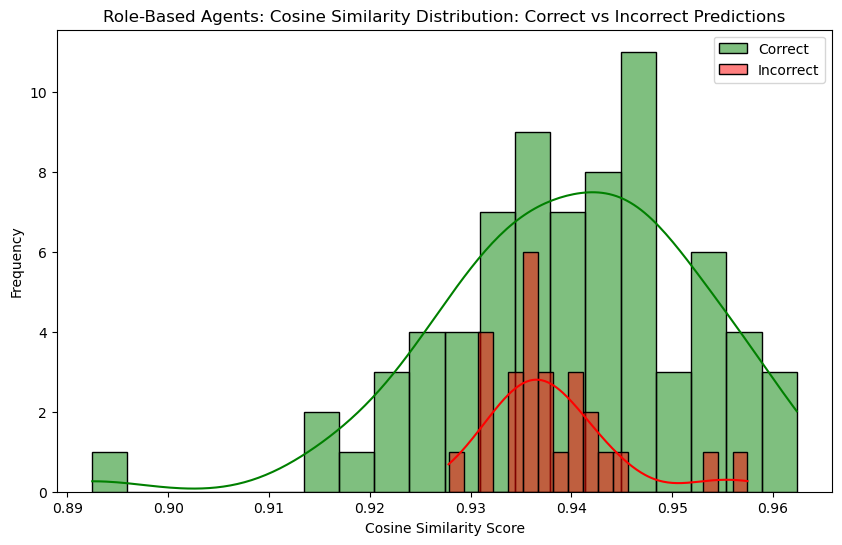

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

# Function to check if there is a hit@5
def check_hit(pred_idx: list, ans_idx: list):
    for idx in pred_idx:
        if idx in ans_idx:
            return 1  # It's a hit
    return 0

# Lists to store correct and incorrect document data
correct_docs = []
incorrect_docs = []
hits_count = 0

# Loop through the test data
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc='Retrieving and Evaluating Testing Data'):
    test_query = {
        'summary': row['summarizer_v1']
    }
    
    correct_doc_ids = [row['Document ID']]
    
    # Retrieve the top 5 documents using neo4j_vector search
    retrieved_docs = neo4j_vector.similarity_search_with_score(test_query['summary'], k=1000, filter={"sector": row['Sector']})
    
    # Collect unique document indices (ignore different chunks from the same document)
    unique_doc_indices = []
    similarities = []
    seen_docs = set()
    for doc, score in retrieved_docs:
        doc_idx = doc.metadata['documentId']
        if doc_idx not in seen_docs:
            unique_doc_indices.append(doc_idx)
            similarities.append(score)  # Collect similarity scores
            seen_docs.add(doc_idx)
        if len(unique_doc_indices) >= 5:
            break
            
    # Check if the correct document is in the top 5 (hit@5)
    is_hit = check_hit(unique_doc_indices, correct_doc_ids)
    
    if is_hit:
        hits_count += 1
        correct_docs.append({
            'doc_id': correct_doc_ids[0],
            'similarity': max(similarities),  # Max similarity for correct document
            'sector': row['Sector'],
            'summary': row['summarizer_RAG_v1']
        })
    else:
        incorrect_docs.append({
            'doc_id': correct_doc_ids[0],
            'similarity': max(similarities),  # Max similarity for incorrect document
            'sector': row['Sector'],
            'summary': row['summarizer_RAG_v1']
        })

# Calculate the hit@5 rate
print('Hit@5 Rate: ', (hits_count / len(test_data)))

# Save the correct and incorrect docs to CSV
correct_df = pd.DataFrame(correct_docs)
incorrect_df = pd.DataFrame(incorrect_docs)
correct_df.to_csv('correct_docs.csv', index=False)
incorrect_df.to_csv('incorrect_docs.csv', index=False)

# Plot similarity distributions
def plot_similarity_distributions(correct_docs, incorrect_docs):
    correct_similarities = [doc['similarity'] for doc in correct_docs]
    incorrect_similarities = [doc['similarity'] for doc in incorrect_docs]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(correct_similarities, bins=20, color='green', label='Correct', kde=True)
    sns.histplot(incorrect_similarities, bins=20, color='red', label='Incorrect', kde=True)
    plt.xlabel('Cosine Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Role-Based Agents: Cosine Similarity Distribution: Correct vs Incorrect Predictions')
    plt.legend()
    
    plt.savefig('role-cosine.svg', format='svg')
    
    plt.show()

# Call the function to plot the distribution
plot_similarity_distributions(correct_docs, incorrect_docs)

## Test QA

In [ ]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.chains import GraphCypherQAChain


# chain = RetrievalQA.from_chain_type(
#     ChatOpenAI(temperature=0), chain_type="stuff", retriever=neo4j_vector.as_retriever(), return_source_documents=True
# )

chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(model='gpt-4o', temperature=0), graph=graph, allow_dangerous_requests=True, verbose=True
)

chain.invoke(
    {"query": "What are South Korea policy related to energy sector in which Standards, obligations and norms is the policy instrument?"},
    return_only_outputs=False,
)

In [ ]:
chain.invoke(
    {"query": "Can you recommend the policy that best dealing with Flood?"},
    return_only_outputs=False,
)

In [66]:
chain.invoke(
    {"query": "What are the policy instruments for Transport sector?"},
    return_only_outputs=False,
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Generated Cypher:
cypher
MATCH (s:Sector {name: "Transport"})<-[:HAS_TARGET_SECTOR]-(pd:PolicyDocument)-[:USES_INSTRUMENT]->(pi:PolicyInstrument)
RETURN pi.name

Full Context:
[{'pi.name': 'Education, training and knowledge dissemination'}, {'pi.name': 'Standards, obligations and norms'}, {'pi.name': 'Subsidies'}, {'pi.name': 'Tax incentives'}, {'pi.name': 'Capacity building'}, {'pi.name': 'Processes, plans and strategies'}, {'pi.name': 'Subnational and citizen participation'}, {'pi.name': 'Research & Development, knowledge generation'}, {'pi.name': 'Subsidies'}, {'pi.name': 'Tax incentives'}]

> Finished chain.


{'query': 'What are the policy instruments for Transport sector?',
 'result': 'The policy instruments for the Transport sector include Education, training and knowledge dissemination, Standards, obligations and norms, Subsidies, Tax incentives, Capacity building, Processes, plans and strategies, Subnational and citizen participation, and Research & Development, knowledge generation.'}